# Labsheet 6: Odometry

This labsheet investigates using the motor information available in the Webots simulation of an e-puck to implement a simple kinematic model.  This will allow for changes of pose (position and rotation) to be estimated.  Tracking the robot pose will become a valuable source of information for your robot.  You will need an estimate of pose to be able to return to the start location (Go Home).  

When we use a Simulator, quite plainly we have access to the exact position of the simulated robot.  In Webots, this is visible in the left hand pane:

INSERT IMAGE


However, our Simulated robot should not have access to this information.  In reality, it is rare that a robotic system will have easily available and exact information.  Even systems like <a href="https://en.wikipedia.org/wiki/Global_Positioning_System">Global Positionining System</a> can suffer issues such as loss of signal, especially within indoor environments.

The information in the left-hand pane is the numerical representation of the robot (i.e., that is the simulation information).  Instead, we will investigate the simulated e-puck robot calculating an estimate of it's own position and rotation (pose).  






<hr><br><br><br><br>

# Overview: Odometry

**`Odometry`** refers to maintaining an estimate of position using sensors.  By using a last-known position and a subsequent measurement of change, it is possible to calculate an estimate of the robot position.  This technique is known as **`dead reckoning`**.

The real e-puck robot utilises `stepper motors`, and this has been simulated in Webots. `Stepper motors` increment their position by fixed angular quantity. When using `stepper motors` to effect changes of position, they can be conveniently regarded to simultaneously encode rotation.  This is achieved by counting the number of times the `stepper motor` has been commanded to increment by one angular position (i.e. "counting steps").  

The count of steps is only true when the motor has enough `torque` to effect the rotation - otherwise, the microcontroller will count rotations in software that did not happen in reality.  As such, counting the step commands sent to a stepper motor is `open loop` control.

In the previous Labsheet "Line Following", you will have developed your first `closed-loop` control system.  Hopefully, your robot was able to follow the line sufficiently well.  This would mean your robot appeared to have an intelligent autonomous behaviour.  It is important to recognise that to achieve this, your robot was utilising a `source of information` from the environment - the line.

<p align="center">
<img width="50%" src="https://github.com/paulodowd/EMATM0053_21_22/blob/main/images/3PI_InfoSource.png?raw=true">
</p>

However, despite the intelligent looking behaviour whilst line following, the robot had no information on how far it had travelled. 

In this labsheet, we will focus on generating more information for your robotic system to later utilise. In other parts of the line following challenge, relying on line following is no longer sufficient.  For instance:
- traversing the gap in the line.
- determining the end of the line.
- returning to home (start position). 

If we can utilise the rotary encoders to estimate the robot position, we can use this information to perform operations such as:
- turn to a specific angle
- move to a specific location
- maintain a straight course of travel
- estimate the distance travelled
- etc.


<hr><br><br><br><br>

# Kinematics

In this section, we will implement a simple kinematic model for the simulated e-puck robot.  This will integrate the contribution of both the left wheel and right wheel to estimate a resultant `pose` of the robot.  In terms of our **`task`**, it would be useful to know:
- the X position of the robot in the `task environment`.
- the Y position of the robot in the `task environment`.
- the rotation of the robot in the `task environment`.

<p align="center">
<img src="https://github.com/paulodowd/EMATM0053_21_22/blob/main/images/3PI_KinematicsOverview.png?raw=true">
</p>

As the robot travels, we will estimate it's position within a `global co-ordinate frame` annotated $X_{I}$, $Y_{I}$. In our task, it is convenient to set the origin of the `global co-ordinate frame` ($X_{I}=0$, $Y_{I}=0$) when the robot is powered on.  Therefore, where your robot is positioned when it is powered on (or reset) will become the origin of it's subsequent position estimations.

Creating a `local co-ordinate frame`, annotated as $X_{R}$, $Y_{R}$, allows us to describe the `configuration` of wheels relative to the robot centre at point $p$.  For our robot, the chassis holds two wheels in a fixed relation (e.g., they are fixed on either side of the robot, and cannot be repositioned).  We assume:
- the robot also has wheels of the same size, radius $r$.  
- the wheels are configured at a distance $l$ and rotated +/- 90&deg; ($\pi/2$) respectively from $X_{R}$. This aligns the direction of travel of both wheels with $X_{R}$.  

We then address the central question of how the rotation velocity of the left and right wheels, $\phi_{l}$ and $\phi_{r}$, will displace the robot within the local frame:

> $\dot{X_{R}} = \frac{r\phi_{l}}{2} + \frac{r\phi_{r}}{2} $
<br> the contribution along $X_{R}$, which we understood as each wheel contributing to half the forward motion of the robot at point $p$. 

> $\dot{Y_{R}} = 0$
<br> the contribution along $Y_{R}$, which we understood as being zero contribution because the wheels are aligned to $X_{R}$ and unable to slide. 

> $\dot{\theta_{R}} = \frac{r\phi_{l}}{2 l} - \frac{r\phi_{r}}{2 l}$
<br>the contribution of rotation, which we understood to describe the counter-active motion of each wheel, if any, proportional to their distance of separation $2l$.  

The above contributions (note, the small dot above the letter indicates they are a contribution) are in the local co-ordinate frame.  Therefore, each component will have a magnitude relative to the local origin.  To utilise these as a displacement in the global co-ordinate frame, they require rotating and translating with respect to the prior pose of the robot.  Rotation is achieved via an `orthogonal rotation matrix` using $\theta_{I}$.  Because $\dot{Y_{R}}$ is always 0 in our simple model, the matrix multiplication simplifies to the following:

<p align="center">
<img width="50%" src="https://github.com/paulodowd/EMATM0053_21_22/blob/main/images/kinematic_update.png?raw=true">
</p>

Including the translation, our update calculation at each time step $t$ is therefore:
<br>
<p align="center">
$X_{I}^{\;t+1} = X_{I}^{\;t} + ( \;\dot{X_{R}} \; cos \; \theta_{I}^{\;t}\; )$
</p>

<p align="center">
$Y_{I}^{\;t+1} = Y_{I}^{\;t} + (\;\dot{X_{R}}\; sin \;\theta_{I}^{\;t}\; )$ 
</p>

<p align="center">
$\theta_{I}^{\;t+1} = \theta_{I}^{\;t} + \dot{\theta_{R}}$
</p>






<hr><br><br><br><br>

## Exercise 1: E-Puck Dimensions

1. Find the dimensions of the simulated e-puck robot.  You should be able to refer to the documentation for either the <a href="https://cyberbotics.com/doc/guide/epuck">simulated e-puck</a> or the <a href="http://www.e-puck.org/">real e-puck</a>.  You will need to find:
  - Wheel Radius
  - Wheel Separation

2. **Validate** the value provided by the motor positions sensors (`wb_distance_sensor_get_value()`).  These have been registered for you within the <a href="https://github.com/paulodowd/EMATM0053_21_22/blob/main/WebotsWorld/Webots_Labs/Webots_Labs/controllers/labsheet_x/labsheet_x.c"> `labsheet_x.c` example provided on GitHub</a>.

```c
// Example code to read wheel rotation.
float l = wb_position_sensor_get_value(left_position_sensor);
float r = wb_position_sensor_get_value(right_position_sensor);
printf("Wheel rotation: %f, %f\n", l, r );
```

  - The position sensor for each wheel reports a value in `radians`, an angle relative to a unit circle (a circle of radius 1).  
  - **Help:** It is likely that your position sensor for each wheel will initialise with an unusual and unknown initial value. We will take this into account in the next exercise.



<hr><br><br><br><br>

## Exercise 2: Implement Kinematics

We will utilise this exercise to introduce the C language construct `struct`, which stands for _structure_.  A struct will allow us to group together a set of variables that are all used in the same context. If you are familiar with C++, Java, Python, or another Object-Oriented langauge, this general concept will be familiar to you.

Within the intended learning outcomes of this set of Labsheets, we will continue to use variables set in `global scope` (placed outside of the `main()` thread).  In the future, a `struct` becomes very useful to pass a lot of variables via the use of `pointers`.  If you'd like to know more about using `pointers`, you can talk to a member of the teaching staff.

We can declare a `struct` to hold the relevant information we need to keep track of the robot pose:

```c
struct Kinematics_s {
  
  // Left wheel
  float l_last_angle;  // angular position of wheel in last loop()
  float l_delta_angle; // calucated difference in wheel angle.

  // Right wheel
  float r_last_angle;  // angular position of wheel in last loop()
  float r_delta_angle; // calucated difference in wheel angle.

  float x;             // Global x position of robot
  float y;             // Global y position of robot
  float th;            // Global theta rotation of robot.
  
}; // A semi-colon finishes the definition.

```

In the above example, the name given to the struct is `Kinematics_s`.  Here, `_s` has been appended to help make the code more readble - later we will see the `_s` and remember we are working with a struct.  You can give a struct a name which is useful and meaningful to you.  

Once we have declared the `struct` (what it will contain), we can then proceed to use it similar to a normal variable.  In the below, we create an instance of this new `struct` variable:

```c
  struct Kinematics_s pose;
// ^^^^^^^^^^^^^^^^^  ^^^^
//  variable "type"   variable name
```

In the rest of our code, we can then access the `struct` to read a value or assign a value in the following ways:

```c
// At top of program, in global scope
struct Kinematics_s pose;

// An example of using "pose" within loop
void loop() {

  // We access variables within a struct using
  // the dot operator.  We have to provide the name
  // of the struct variable (here, "pose"), then a dot
  // then the name of the variable we accessing.

  // Assigns 0 into pose l_last_angle
  pose.l_last_angle = 0;

  // Reads pose x, giving result to printf() 
  printf(" X = %f\n", pose.x );

}

```

1.  Copy the kinematics struct into your Webots code.  If you are following the recommendations, place the struct declaration and `struct Kinematics_s pose` instance into the `global scope` of your code.

2. Ensure that you set the initial values of your `pose` struct variable within `setup()`.
  - What should the initial value of `l_last_angle` and `r_last_angle` be?
  - What should the initial value of `l_delta_angle` be?
  - What should the initial value of `r_delta_angle` be?
  - What should `x`, `y`, `th` initial values be?
  - **Help**: it is necessary to run a step of the simulator within `setup()` to get the initial rotation of the left and right wheels:

```c
void setup() {
  // Existing setup code...
  // ...

  // Get initial rotations for the left and 
  // right wheels
  wb_robot_step(TIME_STEP);
    
  float l = wb_position_sensor_get_value(left_position_sensor);
  float r = wb_position_sensor_get_value(right_position_sensor);

  // Set initial values for the struct
  // ...
  // pose.x = ???
  // pose.y = ???
  // etc...
  

}

```



3. Implement a function to perform the kinematic update for your e-puck robot.  A brief template is provided below:
  - To make your code easier to alter, it is recommended that you use either `#define` or global variables to set:
    - Wheel Radius
    - Wheel Separation
    - Decide which order of magnitude of units you are working in, e.g. `mm`, `cm`, or `m`.  Webots uses `m` by default within it's data fields.

```c
void updateKinematics() {

  // Get current wheel angular positions

  // Use current and last wheel angular positions
  // to determine l_delta_angle and r_delta_angle

  // Since current value has been used, save the current
  // left and right angles into  l_last_angle and 
  // r_last_angle for the next iteration.

  // Apply delta_angle within the kinematic equations provided.
  // 1) Work out forward contribution of motion
  // 2) Work out theta contribution of rotation

  // Update the X, Y and th values.

}

```

4. From within `loop()` implement a call to your kinematic update function (`updateKinematics()`, as above).  
  - Validate that you are gaining a sensible result from your kinematic equations by using `printf()`.






<hr><br><br><br><br>

## Exercise 3: Validate & Evaluate Odometry

Validate that odometry is working as you'd expect.
1. **Forward Travel:**
    - Adapt your program so that your e-puck will travel only forwards at a slow speed.  
    - You can use the information in the left panel, under `DEF EPUCK E-puck` to validate that your odometry is estimating position with an acceptable degree of error.  Inspect the field labelled `translation x.xxx y.yyy z.zzz`. The order of magnitude of your units may differ.
    - It may be useful to set the robot to start at position X=0, Z=0 in the simulator.
    
2. **Rotation:**
    - Adapt your program so that your e-puck will rotation on the spot slowly.
    - You can validate your pose estimation for rotation against the simulator.  Similar to the above, you can set the initial in the left panel, `DEF EPUCK E-puck` rotation to be 0.  You will need to set the field `rotation x.xxx y.yyy z.zzz` y.yyy = 0.00.
    - You can also validate your e-puck rotation against the markings set into the floor of the example arena.


3. Write some motor operation code so that your robot will drive forwards until it reaches a set distance.  Use your new odometry information to achieve this, e.g:
```c
void loop() {

  // Remember to update pose!
  updateKinematics();

  if( pose.x < 400 ) {
      // continue to drive fowards
  } else {
      // stop.
  }

}

```
  - **Evaluate:** Take measurments of your robot's stopping distance.  Collect data from two sources: the internal measurement (calculated pose, odometry) and the external reality (`ground truth`, from the Webots Simulator left-hand panel).  If you are working online in Google Colab, use the provided boxplot code below to plot your data. 
    - Does your robot consistently `overshoot` (stop late), or `undershoot` (stop early)?  
    - How is this visible on your boxplot?
    - Is this a problem with your motor control, or an error in kinematics?
    - In the procedure you have adopted to measure distance, how might you improve the precision and accuracy of your measurements, or your capability to record error?
    - How many repeated trials (or, collected data points) are necessary to give you a clear indication of the system performance?
  - **Hypothesise:** Given the form of the kinematic update equations, which parameter is most likely to effect the performance of the forward ($X_{R}$) contribution?  
    - Adjust likely parameters to see if you can improve the performance, and repeat your evaluation.

    


- Write some motor operation code so that your robot will rotate on the spot to a specific angle.
  - For this exercise, do not use time to perform a rotation.  Instead, write code to control motors via your global co-ordinate $\theta$ value.
  - **Evaluate:** Perform similar evaluations as the above.  Take a number of measurements to `characterise` the performance of your robot. 
    - In the procedure you have adopted to measure distance, how might you improve the precision and accuracy of your measurements, or your capability to record error?
  - **Hypothesise:** Make a similar hypothesis on which parameter most effects the $\theta$ contribution.  Explore parameters to see if you can improve the error when your robot rotates on the spot.

- Consider the observations you have made of translation and rotation movement for your robot.
 - **Hypothesise:** Which of these generates the more significant error in your odometry.  Discuss:
  - possible causes within your robotic system, across environment, hardware, software and task.
  - a rationale for why rotation or translation has the greater impact.

[Text(0, 0.5, 'Rotation Error (degrees)'),
 Text(0.5, 0, 'Implementation'),
 Text(0.5, 1.0, 'Fictional Results')]

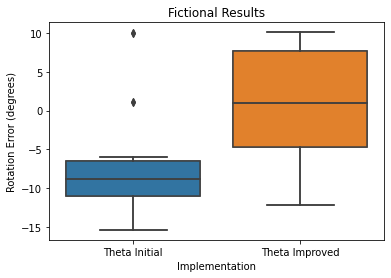

In [ ]:
#
# An example of using Python, Seaborn and
# Pandas to plot data into a Boxplot. 

# We will use a library called Seaborn to 
# make our box plot for us, so we import it.
import seaborn as sns


# To graph more than one dataset is a little 
# complicated.  We need to format the
# data into 'dataframes'.  We use the pandas
# library to do this for us.  Import pandas:
import pandas as pd

# Add your measurements into the arrays
# like the following.  
# Here, these are distance between the
# 3Pi+ center and the line center.
x_error_initial = [-9.1, -12.4, -8.6, -10.3, -15.4, -11.2, 10.0, -6.0, -8.1, 1.1]  
x_error_improved = [-12.2, 10.1, 8.1, -8.2, 0.2, 8.5, -6.4, 6.2, 1.1, 0.8]

th_error_initial = [-9.1, -12.4, -8.6, -10.3, -15.4, -11.2, 10.0, -6.0, -8.1, 1.1]  
th_error_improved = [-12.2, 10.1, 8.1, -8.2, 0.2, 8.5, -6.4, 6.2, 1.1, 0.8]

# You can make further arrays, following the
# pattern:
# pwm_60 = [ , , , ]

# We use the .DataFrame() function to apply a 
# label to each array of results
x_initial_dataframe = pd.DataFrame({'X Initial':x_error_initial})
x_improved_dataframe = pd.DataFrame({'X Improved':x_error_improved})

th_initial_dataframe = pd.DataFrame({'Theta Initial':th_error_initial})
th_improved_dataframe = pd.DataFrame({'Theta Improved':th_error_improved})


# We then add the two dataframes together.
x_combined = pd.concat([ x_initial_dataframe, x_improved_dataframe], axis=0)

th_combined = pd.concat([ th_initial_dataframe, th_improved_dataframe], axis=0)

# We can now plot both datasets at the same time.
plot_x_error = sns.boxplot(data=x_combined)
plot_x_error.set(xlabel ="Implementation", ylabel = "Travel Error (mm)", title ='Fictional Results')

#plot_th_error = sns.boxplot(data=th_combined)
#plot_th_error.set(xlabel ="Implementation", ylabel = "Rotation Error (degrees)", title ='Fictional Results')

<hr><br><br><br><br>

## Exercise 4: Improve Kinematics

**For the line following challenge, the simple kinematic model provided is sufficient to enable your robot to travel back to where it started with reasonable performance.  The exercises in this section can be considered optional or suitable for further work.**  

In the simple model detailed in this labsheet, we have worked with the assumption that the robot will move or rotate, exclusively (either one or the other). As such, our model translates by some amount $X_{R}$ and then rotates this translation motion by some $\theta_{R}$.  These operations are accounted for by the following motor activations:

- when left and right motors have equal non-zero velocity and in the same direction, $v_{l} = v_{r} \ne 0$, the robot will move forwards or backwards in a straight line.
- when the left and right motors have equal non-zero and inversed velocity, $v_{l} = -v_{r} \ne 0$, the robot will rotate on the spot.

This presents the exceptional case when the left and right motor are of different velocity, including cases where one my be 0.  Under these conditions, the robot will move on an arc. 

In our simplified model, we assume that travel on an arc can be sufficiently approximated by the integrating the rotation of the straight line segments generated by $X_{R}$.  

When the wheels have differing velocity, the point of rotation for the movement moves away from point $p$.  This new point of rotation is referred to as the `instantaneous centre of rotation` (ICR).  The more similar the wheels speeds, the further the ICR moves from point $p$.


1. As a matter of interest:
  - **Hypothesise:** If the ICR moves away from point $p$, and so defines an arc of travel for the robot, will the simplified model under-estimate or over-estimate the resultant position in comparison?
2. Implement ICR and the kinematic update routine. 
  - If you need help with this exercise, discuss the matter with the teaching staff. They will help you to decide if you should insatead continue further with labsheets and come back to this later.
  - When working on this implementation, be aware of divide-by-zero errors.
  - Any gain in performance from this implementation is likely to be more pronounced and visible when you address the full line following challenge, especially the return to home objective.  Therefore, you may need to return to this exercise later.  


